# PennFudan Dataset

In [ ]:
# %%bash
# pip install ultralytics
# pip install cython
# pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
# # Download the Penn-Fudan dataset (for image samples)
# wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# unzip PennFudanPed.zip

In [1]:
import os
import numpy as np
import torch
from torch import nn
from torchvision import transforms
from torchvision.ops.boxes import box_iou
import matplotlib.pyplot as plt
from PIL import Image
import cv2
PENNFUDAN_LABEL_NAMES = ['__background__', 'person']

## To CSV

In [59]:
imgs = list(filter(lambda x: x.endswith(".png"), sorted(os.listdir(os.path.join(root, "PNGImages")))))
masks = list(filter(lambda x: x.endswith(".png"), sorted(os.listdir(os.path.join(root, "PedMasks")))))
len(imgs), len(masks)

(170, 170)

```
columns = [
    filename, file_size, file_attributes, region_count, region_id,
    region_shape_attributes, region_attributes
]
```

In [94]:
import json
rows = []
for img_path, mask_path in zip(imgs, masks):
    img = Image.open('./PennFudanPed/PNGImages/' + img_path).convert("RGB")
    mask = Image.open('./PennFudanPed/PedMasks/' + mask_path)
    # convert the PIL Image into a numpy array
    mask = np.array(mask)
    # instances are encoded as different colors
    obj_ids = np.unique(mask)
    # first id is the background, so remove it
    obj_ids = obj_ids[1:]
    # split the color-encoded mask into a set
    # of binary masks
    maskss = mask == obj_ids[:, None, None]
    # get bounding box coordinates for each mask
    num_objs = len(obj_ids)
    boxes = []
    for i in range(num_objs):
        pos = np.where(maskss[i])
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        # original annotation use the bottom left corner as the origin
        # here we reset it to start from top left
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        x = int((xmin))
        y = int((ymin))
        w = int((xmax - xmin))
        h = int((ymax - ymin))
        # make row
        rows.append({
            'filename': '../PennFudanPed/PNGImages/' + img_path,
            'file_size': -1,
            'file_attributes': {},
            'region_count': num_objs,
            'region_id': i,
            'region_shape_attributes': json.dumps({'name': 'rect', 'x': x, 'y': y, 'width': w, 'height': h}),
            'region_attributes': json.dumps({'type': 'Pedestrian'}),
        })

In [95]:
import pandas as pd
ann = pd.DataFrame(rows)
ann

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,../PennFudanPed/PNGImages/FudanPed00001.png,-1,{},2,0,"{""name"": ""rect"", ""x"": 159, ""y"": 181, ""width"": ...","{""type"": ""Pedestrian""}"
1,../PennFudanPed/PNGImages/FudanPed00001.png,-1,{},2,1,"{""name"": ""rect"", ""x"": 419, ""y"": 170, ""width"": ...","{""type"": ""Pedestrian""}"
2,../PennFudanPed/PNGImages/FudanPed00002.png,-1,{},1,0,"{""name"": ""rect"", ""x"": 67, ""y"": 92, ""width"": 12...","{""type"": ""Pedestrian""}"
3,../PennFudanPed/PNGImages/FudanPed00003.png,-1,{},1,0,"{""name"": ""rect"", ""x"": 292, ""y"": 134, ""width"": ...","{""type"": ""Pedestrian""}"
4,../PennFudanPed/PNGImages/FudanPed00004.png,-1,{},2,0,"{""name"": ""rect"", ""x"": 167, ""y"": 59, ""width"": 1...","{""type"": ""Pedestrian""}"
...,...,...,...,...,...,...,...
418,../PennFudanPed/PNGImages/PennPed00094.png,-1,{},1,0,"{""name"": ""rect"", ""x"": 121, ""y"": 26, ""width"": 1...","{""type"": ""Pedestrian""}"
419,../PennFudanPed/PNGImages/PennPed00095.png,-1,{},2,0,"{""name"": ""rect"", ""x"": 192, ""y"": 49, ""width"": 1...","{""type"": ""Pedestrian""}"
420,../PennFudanPed/PNGImages/PennPed00095.png,-1,{},2,1,"{""name"": ""rect"", ""x"": 319, ""y"": 54, ""width"": 1...","{""type"": ""Pedestrian""}"
421,../PennFudanPed/PNGImages/PennPed00096.png,-1,{},2,0,"{""name"": ""rect"", ""x"": 5, ""y"": 37, ""width"": 96,...","{""type"": ""Pedestrian""}"


In [96]:
ann.to_csv('./PennFudanPed/Annotation/PennFudan.csv', index=False)

## Dataset

In [14]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform):
        self.root = root
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(filter(lambda x: x.endswith(".png"), sorted(os.listdir(os.path.join(root, "PNGImages")))))
        self.masks = list(filter(lambda x: x.endswith(".png"), sorted(os.listdir(os.path.join(root, "PedMasks")))))
        # standard transform
        self.raw_transforms = transforms.Compose([
            # fixed transform
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float)
        ])
        self.transforms = transforms.Compose(transform.transforms + self.raw_transforms.transforms)

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            # original annotation use the bottom left corner as the origin
            # here we reset it to start from top left
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # normalize the boxes
        width, height = img.size

        target = {}
        target["raw"] = self.raw_transforms(img)
        target["boxes"] = boxes / torch.tensor([width, height] * 2)
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [15]:
# construct dataset
transform = transforms.Compose([
    # custom transform
    transforms.Grayscale(1),
    transforms.RandomPosterize(4, 1.0),
    transforms.RandomEqualize(1.0),
])

root = './PennFudanPed'
dataset = PennFudanDataset(root, transform)

len(dataset)

170

In [16]:
def draw_boxes(image, bbs, conf=None):
    '''
    Draw bounding boxes given a pair of data points

    Args
    ----
    image -> torch.Tensor: a 3D image tensor of shape [C, W, H]
    bbs -> torch.Tensor: a 2D tensor of shape [#person, 4], each one 
        contains 4 normalized box coordinates [tlx, tly, brx, bry]
    conf -> torch.Tensor: a 1D tensor of shape [#person,], the ith element  
        corresponds to the confidence score of the ith box

    Returns
    ------
    img -> numpy.array: the image with boxes overlaid
    '''

    # convert input to numpy arrays
    # need a copy of the image to function correctly
    img = image.numpy().transpose(1, 2, 0).copy()
    bbs = bbs.numpy()
    width, height = img.shape[:2]
    bbs = np.floor(bbs * np.array([height, width] * 2))

    # draw boxes
    for i, b in enumerate(bbs):
        # retrive the top-left & bottom-right corner
        tlx, tly, brx, bry = int(b[0]), int(b[1]), int(b[2]), int(b[3])
        # cv2 draws the boxes inplace instead of returning a new image
        cv2.rectangle(img, (tlx, tly), (brx, bry), color=(1., 0, 0), thickness=2)

        # if conf is provided, show confidence score
        if conf is not None:
            txt = '{} ({:.2f})'.format(PENNFUDAN_LABEL_NAMES[1], conf[i])
            cv2.putText(img, txt, (tlx, tly - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (1., 0, 0), thickness=1)

    return img

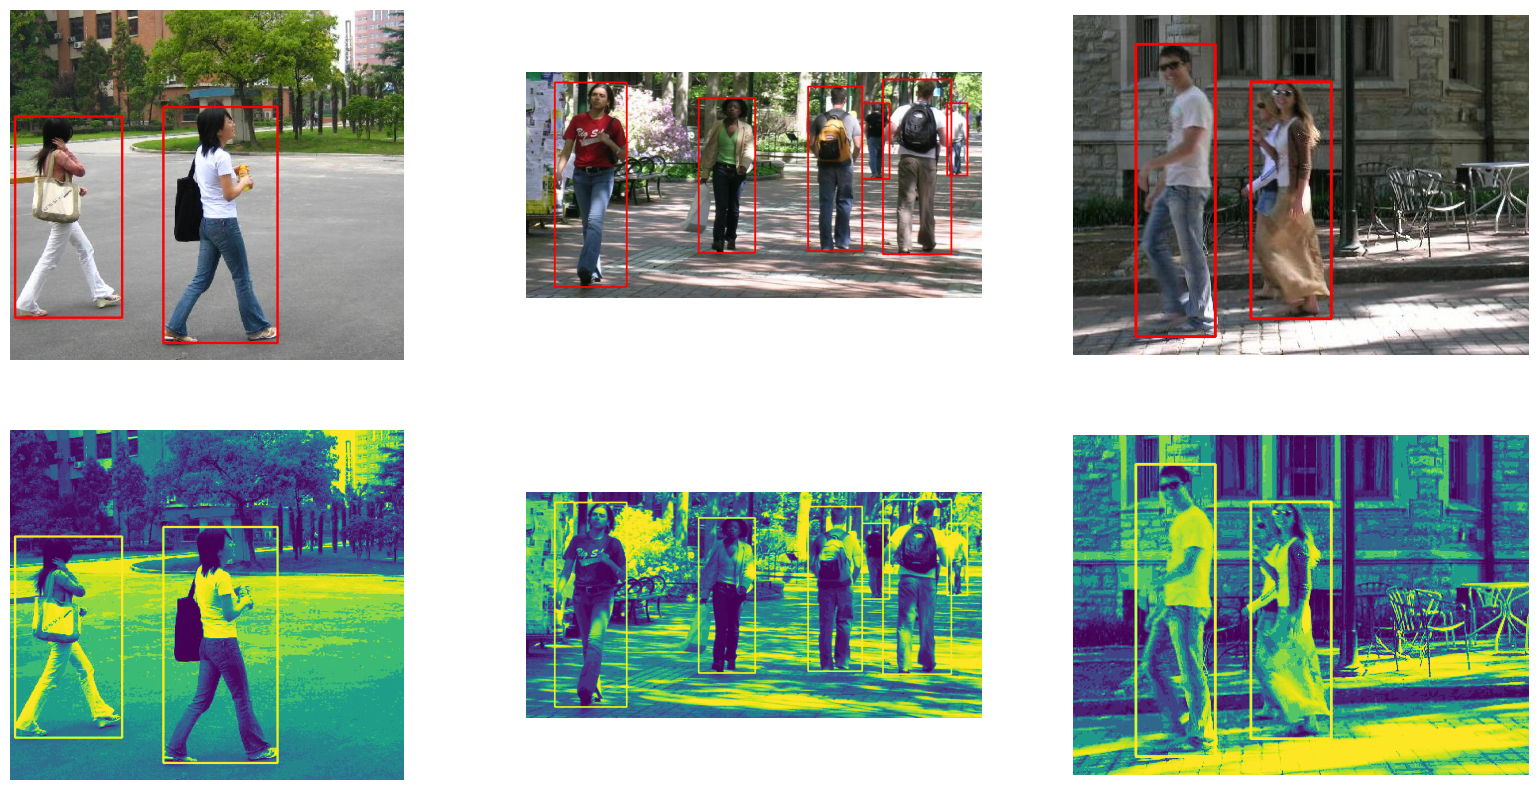

In [17]:
idx = np.random.choice(range(len(dataset)), 3, replace=False)
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

for ii, i in enumerate(idx):
    Xt, yt = dataset[i]
    ax[0][ii].imshow(draw_boxes(yt["raw"], yt['boxes']))
    ax[0][ii].axis('off')
    ax[1][ii].imshow(draw_boxes(Xt, yt['boxes']))
    ax[1][ii].axis('off')

### Split Train/Test

In [18]:
# split dataset
indices = torch.randperm(len(dataset)).tolist()
train_set = torch.utils.data.Subset(dataset, indices[:-50])
test_set = torch.utils.data.Subset(dataset, indices[-50:])

len(train_set), len(test_set)

(120, 50)

### Crop Objects

In [19]:
def get_objects(image, bbs, transform=None):
    '''
    Extract objects (person, background) from given image

    Args
    ----
    image -> torch.Tensor: an image tensor of shape [C, W, H]
    bbs -> torch.Tensor: a label tensor of shape [#person, 4]
    transform: transformations applied to the cropped image

    Returns
    ----
    (ped, bgd) -> (torch.Tensor, torch.Tensor):
        ped - a tensor of shape [#person, C, W, H] containing pedestrains
        bgd - a tensor of shape [4, C, W, H] containing background crops
    '''

    w, h = image.shape[1], image.shape[2]
    bbs = torch.floor(bbs * torch.tensor([h, w, h, w])).int()

    # all pedestrians
    ped = [image[:, b[1]:b[3], b[0]:b[2]].clone() for b in bbs]
    if transform:
        ped = [transform(p) for p in ped]

#     # backgrounds
#     tlx = torch.min(bbs[:, 1])
#     tly = torch.min(bbs[:, 0])
#     brx = torch.max(bbs[:, 3])
#     bry = torch.max(bbs[:, 2])

#     # extract 4 edges per image
#     # note that this can be coarse
#     bgd = torch.stack([
#         transform(image[:, :tlx, :]), 
#         transform(image[:, brx:, :]), 
#         transform(image[:, :, :tly]), 
#         transform(image[:, :, bry:])
#     ])

    return ped #, bgd

In [20]:
# mean [h,w] of the boxes in train_set
h, w = 0, 0
for i, (X, y) in enumerate(train_set):
    ped = get_objects(X, y['boxes'], None)
    hh, ww = 0, 0
    for p in ped:
        # [1, h, w]
        hh += p.shape[1]
        ww += p.shape[2]
    h += hh / len(ped)
    w += ww / len(ped)
h /= len(train_set)
w /= len(train_set)
h, w

(272.186369047619, 109.0880357142857)

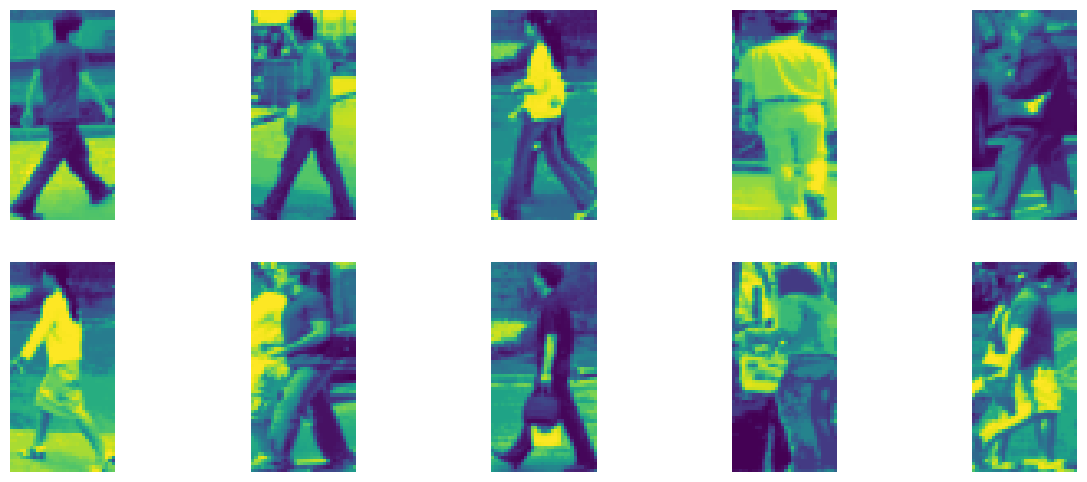

In [21]:
idx = np.random.choice(range(len(train_set)), 10, replace=False)
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
t = transforms.Resize((64, 32), antialias=True)

for i, ii in enumerate(idx):
    X, y = dataset[ii]
    ped = get_objects(X, y['boxes'], t)
    ax[i//5][i%5].imshow(ped[0].numpy().transpose(1, 2, 0))
    ax[i//5][i%5].axis('off')

In [24]:
# save all crops
for i, (X, y) in enumerate(train_set):
    name, ext = dataset.imgs[y['image_id'].item()].split('.')
    ped = get_objects(X, y['boxes'], t)
    for j, p in enumerate(ped):
        p = p.numpy().transpose(1, 2, 0) * 255
        img = Image.fromarray(p.astype(np.uint8).squeeze(), 'L')
        img.save('PennFudanPed/Crops/train/{}_{}.{}'.format(name, j, ext))
    ped = get_objects(y['raw'], y['boxes'], None)
    for j, p in enumerate(ped):
        p = p.numpy().transpose(1, 2, 0) * 255
        img = Image.fromarray(p.astype(np.uint8).squeeze())
        img.save('PennFudanPed/Crops/train_raw/{}_{}.{}'.format(name, j, ext, y["iscrowd"][j].item()))

# save all crops
for i, (X, y) in enumerate(test_set):
    name, ext = dataset.imgs[y['image_id'].item()].split('.')
    ped = get_objects(X, y['boxes'], t)
    for j, p in enumerate(ped):
        p = p.numpy().transpose(1, 2, 0) * 255
        img = Image.fromarray(p.astype(np.uint8).squeeze(), 'L')
        img.save('PennFudanPed/Crops/test/{}_{}.{}'.format(name, j, ext))
    ped = get_objects(y['raw'], y['boxes'], None)
    for j, p in enumerate(ped):
        p = p.numpy().transpose(1, 2, 0) * 255
        img = Image.fromarray(p.astype(np.uint8).squeeze())
        img.save('PennFudanPed/Crops/test_raw/{}_{}.{}'.format(name, j, ext))

## Dict

In [40]:
from glob import glob
train_imgs = sorted(glob('PennFudanPed/Crops/train/*.png'))
test_imgs = sorted(glob('PennFudanPed/Crops/test/*.png'))
len(train_imgs), len(test_imgs)

(301, 122)

In [41]:
train_dict = []
for i in train_imgs:
    train_dict.append(np.array(Image.open(i)))

test_dict = []
for i in test_imgs:
    test_dict.append(np.array(Image.open(i)))

train_dict = np.stack(train_dict, axis=0)
test_dict = np.stack(test_dict, axis=0)
train_dict.shape, test_dict.shape

((301, 64, 32), (122, 64, 32))

In [42]:
mean = np.mean(train_dict, axis=0)
std = np.std(train_dict, axis=0)
mean.shape, std.shape

((64, 32), (64, 32))

In [43]:
eps = 1e-5
train_dict = (train_dict - mean) / std
test_dict = (test_dict - mean) / std

In [44]:
np.save('PennFudanPed/Dict/train_dict.npy', train_dict)
np.save('PennFudanPed/Dict/test_dict.npy', test_dict)